### Package imports

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

### Import the dataset
The datasets contains data of claim counts for different policyholders with certain characteristics. The columns of the dataset are:
   - **AGEPH**: Age of policyholder.
   - **CODPOSS**: Postal code of residency.
   - **duree**: Exposure rate.
   - **lnexpo**: Logarithm of exposure rate.
   - **nbrtotc**: Number of total claims.
   - **nbrtotan**: ?
   - **chargtot**: Total claim amount.
   - **agecar**: Age of car.
   - **sexp**: Sex of person.
   - **fuelc**: Type of fuel of car.
   - **split**: How many splits for the yearly payment.
   - **usec**: Professional or private use of the car.
   - **fleetc**: Is car part of a fleet?
   - **sportc**: Is car a sports car?
   - **coverp**: Type of cover.
   - **powerc**: Power of the car.

In [115]:
df = pd.read_csv('../data/portfolio_data.csv')
df.head()

,AGEPH,CODPOSS,duree,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66
3,37,1030,0.169863,-1.772763,0,0.000000,0.000000,2-5,Female,Petrol,Once,Professional,No,No,MTPL+++,66-110
4,29,1030,1.000000,0.000000,0,0.000000,0.000000,6-10,Female,Petrol,Once,Private,No,No,MTPL+,<66


### Some preprocessing
 - Change column names to lower case
 - Change column names to more descriptive names
 - Change datatypes of columns (in this case all 'objects'should be 'categorical')

In [116]:
df = df.rename(lambda x: x.lower(), axis=1)
df = df.rename(columns={'duree': 'exposure'})


df['agecar'] = pd.Categorical(df['agecar'], ordered=True, categories=['0-1', '2-5', '6-10', '>10'])
df['sexp'] = pd.Categorical(df['sexp'], categories=['Male', 'Female'])
df['fuelc'] = pd.Categorical(df['fuelc'], categories=['Petrol', 'Gasoil'])
df['split'] = pd.Categorical(df['split'], categories=['Once', 'Twice', 'Thrice', 'Monthly'])
df['usec'] = pd.Categorical(df['usec'], categories=['Private', 'Professional'])
df['fleetc'] = pd.Categorical(df['fleetc'], categories=['No', 'Yes'])
df['sportc'] = pd.Categorical(df['sportc'], categories=['No', 'Yes'])
df['coverp'] = pd.Categorical(df['coverp'], categories=['MTPL', 'MTPL+', 'MTPL+++'])
df['powerc'] = pd.Categorical(df['powerc'], ordered=True, categories=['<66', '66-110', '>110'])

df.dtypes

ageph          int64
codposs        int64
exposure     float64
lnexpo       float64
nbrtotc        int64
nbrtotan     float64
chargtot     float64
agecar      category
sexp        category
fuelc       category
split       category
usec        category
fleetc      category
sportc      category
coverp      category
powerc      category
dtype: object

## Explaratory Data Analysis
### Getting some insights in the data by looking at distributions of all the columns

We want to predict the number of claims, let's first look at this variable (**nbrtotc**)

0    145312
1     16602
2      1562
3       162
4        17
5         2
Name: nbrtotc, dtype: int64
Average claim per policyholder: 0.12397880933904447 
Average expected annual claim frequency: 0.1393355156734497 


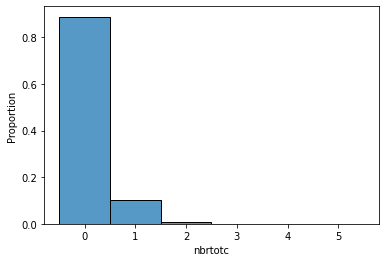

In [117]:
print(df["nbrtotc"].value_counts())
print(f'Average claim per policyholder: {df["nbrtotc"].mean()} ')
print(f'Average expected annual claim frequency: {df["nbrtotc"].sum() / df["exposure"].sum()} ')

sns.histplot(x='nbrtotc', data=df, discrete=True, stat='proportion')
plt.show()

#### Continuous / count data

Let's take a look at our feature variables we can use.
First let's look at the available ages and at the exposure of our policyholders (for what fraction of the year have they been a policyholder). Exposure rate will be used as a weight in our models.

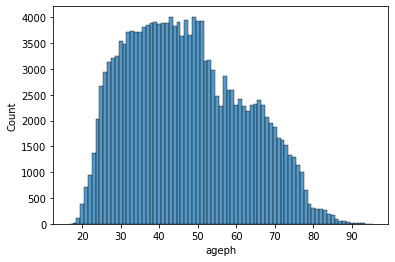

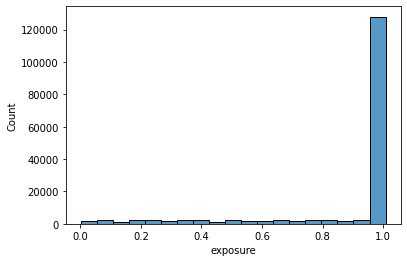

In [119]:
sns.color_palette("light:b", as_cmap=True)
for col in ['ageph', 'exposure']:
    sns.histplot(x=col, data=df, discrete=str(df[col].dtype).startswith('int'))
    plt.show()
    

#### Categorical data
The other predictors are categorical, so let's visualise them in a countplot.

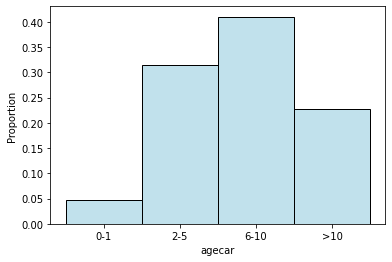

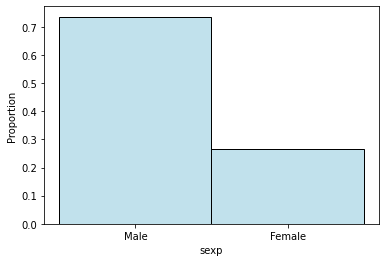

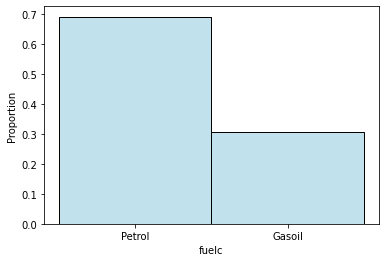

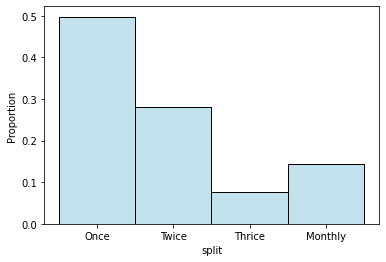

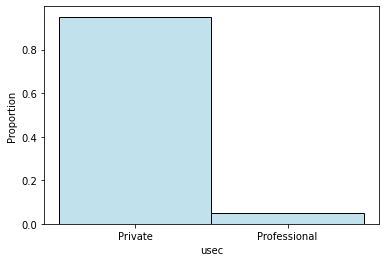

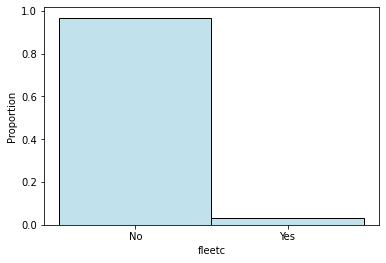

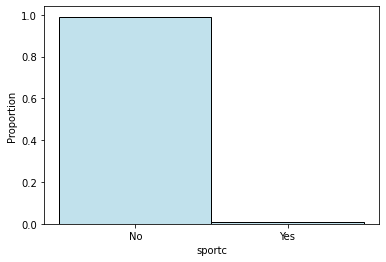

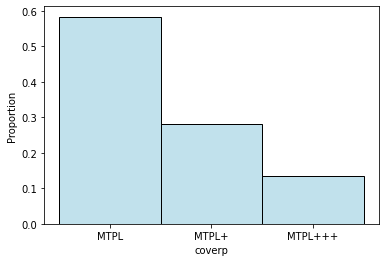

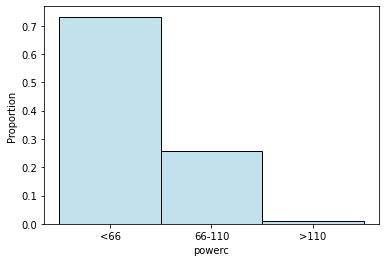

In [120]:
for col in ['agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc', 'coverp', 'powerc']:
    sns.histplot(x=col, data=df, color='lightblue', stat='proportion')
    plt.show()

#### Spatial data

Lastly we still have the postal code, let's map this to a longitude and lattitude (using a 'mapper file')

In [121]:
postal_code_df = pd.read_excel('../data/postcode_long_lat.xlsx') 

# Dataframe we will use to plot our differences in long and lat
postal_code_df_plot = postal_code_df.copy()
postal_code_df_plot['exposure'] = 1
postal_code_df_plot['ageph'] = 25
postal_code_df_plot['agecar'] = '2-5'
postal_code_df_plot['sexp'] = 'Male'
postal_code_df_plot['fuelc'] = 'Petrol'
postal_code_df_plot['split'] = 'Once'
postal_code_df_plot['usec'] = 'Private'
postal_code_df_plot['fleetc'] = 'No'
postal_code_df_plot['sportc'] = 'No'
postal_code_df_plot['coverp'] = 'MTPL'
postal_code_df_plot['powerc'] = '<66'

df = pd.merge(df, postal_code_df, how='inner', left_on = 'codposs', right_on = 'postcode')
df.drop(columns='postcode', inplace=True)
df.head()

,ageph,codposs,exposure,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,long,lat
0,64,1000,1.000000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL+,66-110,4.356488,50.844842
1,28,1000,0.046575,-3.066684,1,21.470588,155.974606,6-10,Female,Petrol,Twice,Private,No,No,MTPL,66-110,4.356488,50.844842
2,58,1000,0.402740,-0.909465,0,0.000000,0.000000,>10,Female,Petrol,Thrice,Private,No,No,MTPL,<66,4.356488,50.844842
3,62,1000,1.000000,0.000000,0,0.000000,0.000000,>10,Female,Petrol,Once,Private,No,No,MTPL+,<66,4.356488,50.844842
4,41,1000,1.000000,0.000000,1,1.000000,62.419590,6-10,Female,Petrol,Monthly,Private,No,No,MTPL,66-110,4.356488,50.844842


##### Using shapefiles to visualize spatial data

We can now use a shapefile of Belgium to visualise it. A shapefile is similar to a DataFrame, but has an extra column geometry, which can be used to draw the shapes/maps.

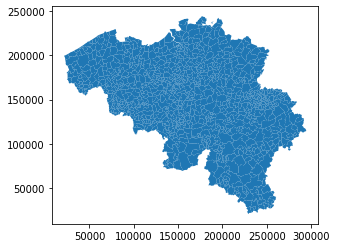

,postcode,naam1,naam2,postcodela,shape_leng,shape_area,geometry
0,1300,None,Wavre,1300,42814.060573,3.262972e+07,"POLYGON ((162947.572 159381.984, 163040.294 15..."
1,1301,None,Bierges,1301,15954.491493,9.641834e+06,"POLYGON ((162471.560 157070.795, 162293.861 15..."
2,1310,None,La Hulpe,1310,20276.463381,1.538129e+07,"POLYGON ((153194.489 158380.695, 153665.832 15..."
3,1315,None,Incourt,1315,43080.689350,3.863840e+07,"POLYGON ((175705.493 159727.847, 176442.771 15..."
4,1320,None,Beauvechain,1320,29647.869458,3.881227e+07,"POLYGON ((172550.654 164380.072, 172812.617 16..."


In [122]:
sf = gpd.read_file('../shapefile/npc96_region_Project1.shp')
sf = sf.rename(lambda x: x.lower(), axis=1)

sf.plot()
plt.show()
sf.head()

We can visualise the relative exposure per area for every city/village in Belgium.

In [123]:
by_postcode = df.groupby('codposs')['exposure'].sum()

sf = pd.merge(sf, by_postcode.to_frame(name='exposure'), how='outer', left_on='postcode', right_index=True)
sf['exposure'] = sf['exposure'].fillna(0)
sf['exposure_per_area'] = sf['exposure'] / sf['shape_area']

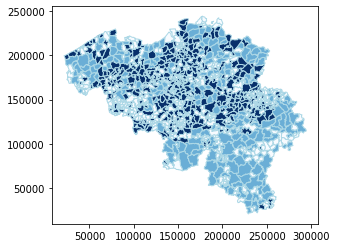

,postcode,naam1,naam2,postcodela,shape_leng,shape_area,geometry,exposure,exposure_per_area
431,4620,None,Fl ron,4620,7745.298159,3.186818e+06,"POLYGON ((243017.211 145044.013, 242942.655 14...",490.260274,0.000154
208,3000,None,Leuven,3000,16960.064156,8.439297e+06,"MULTIPOLYGON (((170521.488 174589.907, 170703....",1314.734247,0.000156
804,7330,None,Saint-Ghislain,7330,8804.747241,3.976136e+06,"POLYGON ((111537.698 127395.990, 111047.404 12...",945.646575,0.000238
106,2000,None,Antwerpen 1,2000,16010.433045,4.845634e+06,"POLYGON ((149569.543 210461.909, 150035.984 21...",4149.923288,0.000856
596,6000,None,Charleroi,6000,8770.144249,3.564524e+06,"POLYGON ((156157.921 123970.270, 156058.484 12...",4523.890411,0.001269


In [124]:
sf.plot(column='exposure_per_area', scheme='Quantiles', k=3, cmap='Blues', edgecolor='lightblue')
plt.show()

sf.sort_values(by='exposure_per_area').tail()

Clearly, the northern part (Flanders) has more exposure than the sourthern part (Wallonia). (This is due to the Ardennes).

### Univariate analysis of effect of predictor variables on claim count.

#### Age of policyholder
Effect of 'continous' age variable tells us that by aging (and getting more experienced behind the wheel), the number of claims decreases. This decrease stops at age 65). We also see the uncertainty is bigger for young and old ages (less data available).

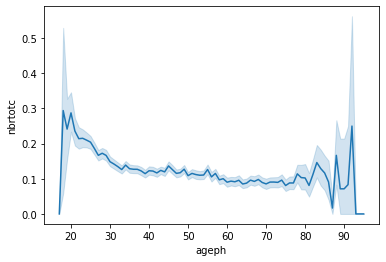

In [125]:
sns.lineplot(x='ageph', y='nbrtotc', data=df)
plt.show()

#### Continuous variables

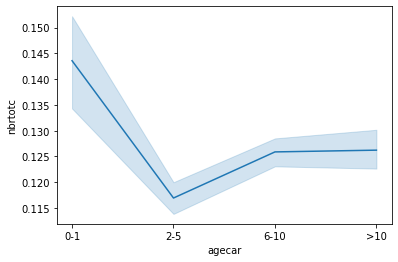

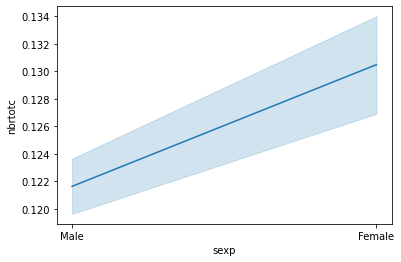

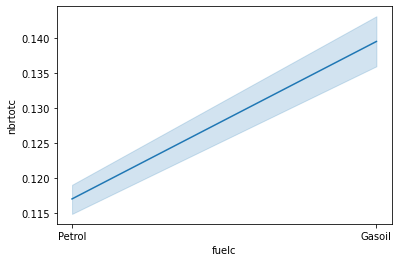

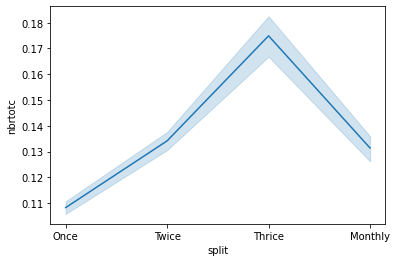

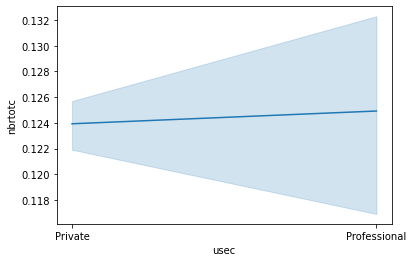

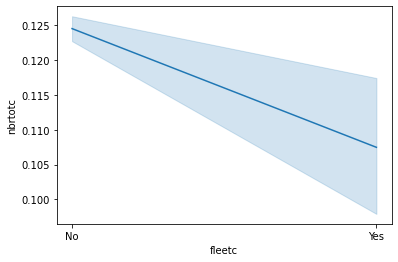

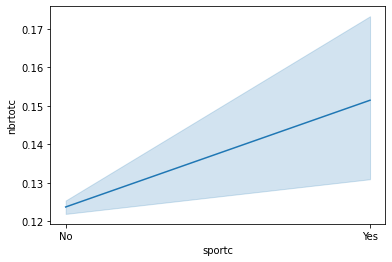

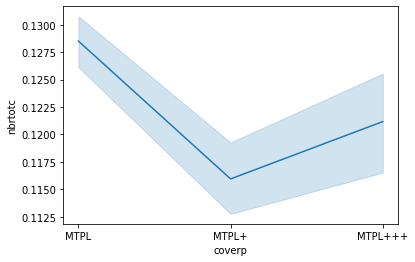

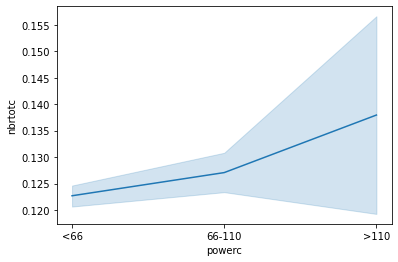

In [126]:
for col in ['agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc', 'coverp', 'powerc']:
    temp = df.groupby(col)['nbrtotc'].mean()
    sns.lineplot(x=col, y='nbrtotc', data=df)
    plt.show()

##### Interaction between age of policyholder and power of car.

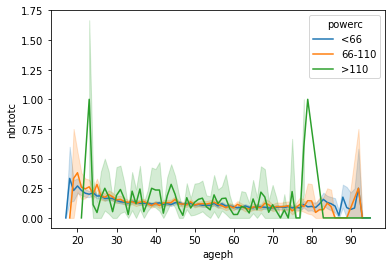

In [127]:
sns.lineplot(x='ageph', y='nbrtotc', hue='powerc', data=df)
plt.show()

## Modelling 

### Splitting in training and test

In [235]:
from sklearn.model_selection import train_test_split

y = df['nbrtotc'].values

X_train, X_test, y_train, y_test = train_test_split(df.index, y, test_size=0.2, random_state=42, stratify=y)

X_train = df.iloc[X_train]
X_test = df.iloc[X_test]
X_train.head()

,ageph,codposs,exposure,lnexpo,nbrtotc,nbrtotan,chargtot,agecar,sexp,fuelc,split,usec,fleetc,sportc,coverp,powerc,long,lat
462,39,1000,1.00000,0.000000,0,0.000000,0.000000,6-10,Male,Gasoil,Once,Private,No,No,MTPL+,66-110,4.356488,50.844842
115164,51,3830,0.99726,-0.002743,1,1.002747,150.372212,2-5,Male,Gasoil,Once,Private,No,No,MTPL,<66,5.321954,50.842960
22419,66,2000,1.00000,0.000000,0,0.000000,0.000000,>10,Male,Petrol,Once,Private,No,No,MTPL+++,<66,4.388418,51.215509
40343,50,4100,1.00000,0.000000,0,0.000000,0.000000,>10,Male,Petrol,Twice,Private,No,No,MTPL,<66,5.501861,50.582629
144801,46,1770,1.00000,0.000000,0,0.000000,0.000000,2-5,Female,Petrol,Once,Private,No,No,MTPL,<66,4.083337,50.865722


### GAM

In [236]:
from pygam.pygam import PoissonGAM
from pygam import s, te, f


In [263]:
# Preprocessing for GAM

y = X_train['nbrtotc'].values
X_df = X_train[['ageph', 'agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc', 'coverp', 'powerc', 'long', 'lat']]
spatial_plot_X_df = postal_code_df_plot[['ageph', 'agecar', 'sexp', 'fuelc', 'split', 'usec', 'fleetc', 'sportc', 'coverp', 'powerc', 'long', 'lat']]

mapping_agecar = {
    '0-1': 0,
    '2-5': 1,
    '6-10': 2, 
    '>10': 3
}

mapping_sexp = {
    'Male': 0,
    'Female': 1
}

mapping_fuelc = {
    'Petrol': 0,
    'Gasoil': 1
}

mapping_split = {
    'Once': 0,
    'Twice': 1,
    'Thrice': 2,
    'Monthly': 3
}

mapping_usec = {
    'Private': 0,
    'Professional': 1
}

mapping_fleetc = {
    'No': 0,
    'Yes': 1
}

mapping_sportc = {
    'No': 0,
    'Yes': 1
}

mapping_coverp = {
    'MTPL': 0,
    'MTPL+': 1,
    'MTPL+++': 2
}

mapping_powerc = {
    '<66': 0,
    '66-110': 1,
    '>110': 2
}



X_df = X_df.replace(
    {
        'agecar': mapping_agecar,
        'sexp': mapping_sexp,
        'fuelc': mapping_fuelc,
        'split': mapping_split,
        'usec': mapping_usec,
        'fleetc':mapping_fleetc,
        'sportc': mapping_sportc,
        'coverp': mapping_coverp,
        'powerc': mapping_powerc
    }
)
spatial_plot_X_df = spatial_plot_X_df.replace(
    {
        'agecar': mapping_agecar,
        'sexp': mapping_sexp,
        'fuelc': mapping_fuelc,
        'split': mapping_split,
        'usec': mapping_usec,
        'fleetc':mapping_fleetc,
        'sportc': mapping_sportc,
        'coverp': mapping_coverp,
        'powerc': mapping_powerc
    }
)

X = X_df.values
spatial_plot_X = spatial_plot_X_df.values

exposure = X_train['exposure'].values
spatial_plot_exposure = postal_code_df_plot['exposure'].values

In [264]:
# Fit GAM
gam = PoissonGAM(te(10, 11) + s(0) + f(1) + f(3) + f(4) + f(8) + te(0, 9))
gam.fit(X, y, exposure=exposure)

PoissonGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, 
   terms=te(10, 11) + s(0) + f(1) + f(3) + f(4) + f(8) + te(0, 9) + intercept,
   tol=0.0001, verbose=False)

In [239]:
gam.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     64.4997
Link Function:                          LogLink Log Likelihood:                                -50198.7785
Number of Samples:                       130925 AIC:                                           100526.5565
                                                AICc:                                          100526.6231
                                                UBRE:                                                2.537
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0307
Feature Function                  Lam

C:\Users\thi12\AppData\Local\Temp\ipykernel_13360\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


Using AIC this is our best model.
We can now visualise the different smoothers

**Age smoother**

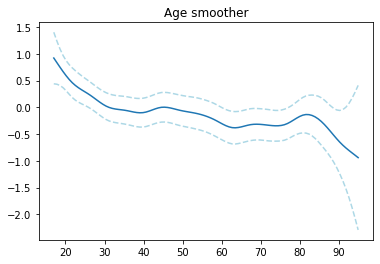

In [265]:
# Visualise age term (second term in our GAM)
XX = gam.generate_X_grid(term=1)

# Age is first term in our data X
plt.plot(XX[:, 0], gam.partial_dependence(term=1, X=XX))
plt.plot(XX[:, 0], gam.partial_dependence(term=1, X=XX, width=.95)[1], c='lightblue', ls='--')
plt.title('Age smoother')
plt.show()

**Spatial smoother**

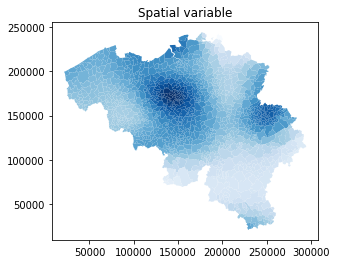

In [266]:
# Visualise our spatial smoother using our shapefile
postal_code_df_plot['GAM_predictions'] = pd.Series(gam.predict(spatial_plot_X, exposure=spatial_plot_exposure))
sf['GAM_prediction'] = postal_code_df_plot['GAM_predictions']


sf.plot(column='GAM_prediction', cmap='Blues')
plt.title('Spatial variable')
plt.show()


**Interaction smoother between age of policyholder and power of car**

<IPython.core.display.Javascript object>


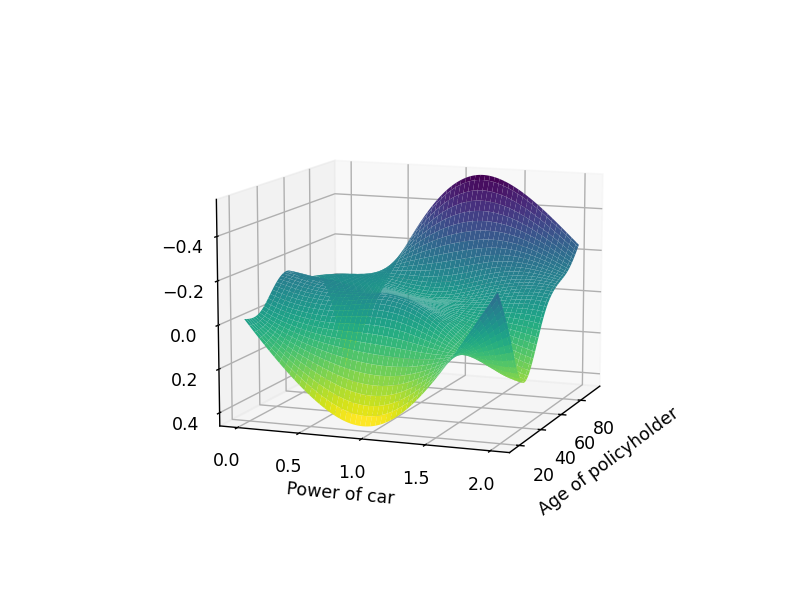

[1. 0. 0. ... 0. 0. 1.]


In [269]:
%matplotlib notebook
XX = gam.generate_X_grid(term=6, meshgrid=True)
Z = gam.partial_dependence(term=6, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
plt.xlabel('Age of policyholder')
plt.ylabel('Power of car')
plt.show()
print(X[:,9])